# British Airways Customer Sentiment Analysis

In this report, we analyse customer reviews to assess the sentiment toward British Airways. Utilizing data from Skytrax, where we scraped 1000 reviews, we applied sentiment analysis to understand the customers' perspectives. The aim was to identify common themes in passenger experiences, particularly focusing on aspects that influence satisfaction levels.

The findings from this analysis are intended to offer British Airways insights into areas of strength and opportunities for service enhancement. By the end of this report, we will have provided a clear depiction of customer sentiment, grounded in data-driven analysis. As a culmination of this report, we present a Tableau dashboard visualizing the key findings and sentiments derived from the analysis: [Tableau Dashboard](https://public.tableau.com/views/BritishAirwaysCustomerReviewSentimentAnalysis/sentiment_analysis?:language=en-US&:display_count=n&:origin=viz_share_link) 


In [24]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud


from tqdm.notebook import tqdm
from time import sleep

## Web Scraping 
This section details the automated process of collecting 1000 recent customer reviews of British Airways from the Airline Quality website. Using Python and BeautifulSoup, we systematically extract the review texts and their respective dates for subsequent analysis.

In [6]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 100
page_size = 10

reviews = {
    'review': [],
    'date': [],
}

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"}

for i in tqdm(range(1, pages + 1), desc="Scraping reviews"):

    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # will raise an HTTPError if the HTTP request returned an unsuccessful status code
    except requests.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
    except Exception as err:
        print(f"An error occurred: {err}")
    else:
        parsed_content = BeautifulSoup(response.content, 'html.parser')

        for para in parsed_content.find_all("div", {"class": "text_content"}):
            reviews['review'].append(para.get_text().strip())  # strip() to remove extra white spaces
        
        for time_tag in parsed_content.find_all("time", {"itemprop": "datePublished"}):
            reviews['date'].append(time_tag['datetime'])

    sleep(0.5)  # Sleep to avoid overwhelming the server

Scraping reviews:   0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
df = pd.DataFrame.from_dict(reviews)
df.head()

,review,date
0,✅ Trip Verified | The plane was extremely dir...,2024-01-15
1,Not Verified | Overall journey wasn’t bad howe...,2024-01-12
2,✅ Trip Verified | Overall very satisfied. Gro...,2024-01-12
3,✅ Trip Verified | As always when I fly BA it ...,2024-01-09
4,✅ Trip Verified | First time using BA busines...,2024-01-07


In [8]:
df.shape

(1000, 2)

## Data Cleaning and Transformation

In this section, we refine the scraped review data to ensure its quality and suitability for analysis. The data is cleaned of unwanted words to enhance the robustness of our sentiment analysis.

**Enhancements Made:**

**Verification Status:** We discern the verification status of each review by searching for specific phrases within the text and assign a new column accordingly.

**Unique Identifiers:** An 'ID' column is added to serve as a unique identifier for each review.

**Date Formatting:** The 'date' column is converted into a standard datetime format to facilitate time-based analysis.

**Text Cleaning:** Unnecessary characters and branding terms are removed from the review texts to focus on the sentiment content. This includes stripping out emojis, symbols, and specific phrases like "Trip Verified".

**Whitespace Management:** We ensure there are no leading or trailing whitespaces in the review texts.

**Stopword Removal**: Using NLTK, a comprehensive list of stopwords is downloaded and utilized to filter out non-substantive words from the review texts, including common airline-related terms that do not contribute to sentiment analysis.

The result is a clean dataset, with each review text transformed into a clean and analysis-ready format.



In [9]:
# Removing all whitespaces
df['review'] = df['review'].apply(lambda x: x.strip())

# Adding a new column for verification status
df['verification_status'] = df['review'].apply(lambda x:'Verified ' if 'Trip Verified' in x else 'Not Verified')

# Adding a new column for ID
df.insert(0, 'ID', range(1, len(df) + 1))

# Converting datetime column
df['date'] = pd.to_datetime(df['date'])

# Removing unwanted words and characters
df['review'] = df['review'].str.replace('✅', '').str.replace('|', '').str.replace('Trip Verified', '').str.replace('Not Verified', '').str.strip()
df.head()

,ID,review,date,verification_status
0,1,The plane was extremely dirty with chocolate s...,2024-01-15,Verified
1,2,"Overall journey wasn’t bad however at the end,...",2024-01-12,Not Verified
2,3,Overall very satisfied. Ground staff member at...,2024-01-12,Verified
3,4,As always when I fly BA it was a total shamble...,2024-01-09,Verified
4,5,First time using BA business class but we were...,2024-01-07,Verified


In [10]:
# Checking for missing values
df.isnull().sum()

ID                     0
review                 0
date                   0
verification_status    0
dtype: int64

In [11]:
# Download stopwords 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/beast/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
# Function to clean text
def clean_text(text):
    # List of additional words to remove
    additional_stopwords = {'british', 'airways', 'ba', 'flight', 'flights', 'aircraft', 'plane', 'airline', 
                            'seat', 'check', 'boarding', 'fly', 'flying', 'london', 'heathrow', 'glasgow', 'frankfurt',
                           'stockholm'}

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove stopwords and additional words
    stop_words = set(stopwords.words('english')).union(additional_stopwords)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [13]:
df.insert(2, 'cleaned_review', df['review'].apply(clean_text))
df.head()

,ID,review,cleaned_review,date,verification_status
0,1,The plane was extremely dirty with chocolate s...,extremely dirty chocolate smudged mine childre...,2024-01-15,Verified
1,2,"Overall journey wasn’t bad however at the end,...",overall journey wasnt bad however end baggage ...,2024-01-12,Not Verified
2,3,Overall very satisfied. Ground staff member at...,overall satisfied ground staff member yvr extr...,2024-01-12,Verified
3,4,As always when I fly BA it was a total shamble...,always total shambles booked manchester madrid...,2024-01-09,Verified
4,5,First time using BA business class but we were...,first time using business class pleased servic...,2024-01-07,Verified


## Sentiment Classification

This segment includes sentiment analysis on the customer reviews using the RoBERTa model, a state-of-the-art natural language processing tool.

**Procedure and Enhancements:**

**Model Setup:** We initialize the RoBERTa model and tokenizer specifically fine-tuned for sentiment analysis on Twitter data, which is adept at interpreting short, opinionated text similar to customer feedback.

**Sentiment Scoring Function:** A custom function, polarity_scores_roberta, is crafted to encode the review texts, pass them through the model, and apply the softmax function to the outputs to obtain probabilities for negative, neutral, and positive sentiments.

**Results Integration:** A new DataFrame, results_df, is created to capture the sentiment scores, which is then merged back with the main DataFrame to associate each review with its corresponding sentiment analysis.

**Rating Computation:** We convert the positive sentiment scores into a rating on a 1 to 5 scale to simplify the interpretation of the results.

The resulting DataFrame now contains the original data, the cleaned reviews, and a set of new columns capturing the sentiment scores and computed rating, providing a comprehensive base for further analysis and reporting.

In [14]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [15]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [16]:
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'neg_score' : scores[0],
        'neu_score' : scores[1],
        'pos_score' : scores[2]
    }
    return scores_dict

In [17]:
res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['review']
        myid = row['ID']
        res[myid] = polarity_scores_roberta(text)
    
    except RuntimeError:
        print(f'Broke for ID {myid}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Broke for ID 21
Broke for ID 68
Broke for ID 101
Broke for ID 123
Broke for ID 168
Broke for ID 182
Broke for ID 237
Broke for ID 242
Broke for ID 261
Broke for ID 284
Broke for ID 292
Broke for ID 370
Broke for ID 390
Broke for ID 455
Broke for ID 514
Broke for ID 536
Broke for ID 591
Broke for ID 660
Broke for ID 661
Broke for ID 798
Broke for ID 822
Broke for ID 855
Broke for ID 955
Broke for ID 979


In [18]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'ID'})
df = df.merge(results_df, on = 'ID', how='right')

In [48]:
# Calculate rating (on a scale of 1 to 5)
df['rating'] = df['pos_score'].apply(lambda x: 1 + round(4 * x))
df.head()

,ID,review,cleaned_review,date,verification_status,neg_score,neu_score,pos_score,rating
0,1,The plane was extremely dirty with chocolate s...,extremely dirty chocolate smudged mine childre...,2024-01-15,Verified,0.922248,0.069026,0.008725,1
1,2,"Overall journey wasn’t bad however at the end,...",overall journey wasnt bad however end baggage ...,2024-01-12,Not Verified,0.756327,0.213367,0.030306,1
2,3,Overall very satisfied. Ground staff member at...,overall satisfied ground staff member yvr extr...,2024-01-12,Verified,0.055850,0.223033,0.721117,4
3,4,As always when I fly BA it was a total shamble...,always total shambles booked manchester madrid...,2024-01-09,Verified,0.885707,0.095301,0.018992,1
4,5,First time using BA business class but we were...,first time using business class pleased servic...,2024-01-07,Verified,0.011003,0.082043,0.906955,5


## Results and Conclusion

In this section, we synthesize the findings from our sentiment analysis and present them through intuitive visualizations. This culminates in a comprehensive overview of customer sentiments towards British Airways, highlighting areas of concern and opportunities for improvement.

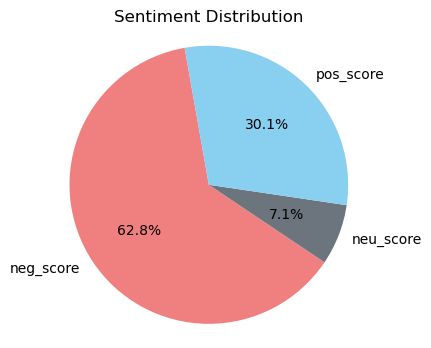

In [56]:
# Calculate the count of each sentiment
sentiment_counts = df[['neg_score', 'neu_score', 'pos_score']].idxmax(axis=1).value_counts()

# Define labels based on the column names used for sentiment scores
labels = ['neg_score', 'neu_score', 'pos_score']

# Extract the counts for each sentiment to match the labels
counts = [sentiment_counts.get(sent, 0) for sent in labels]

# Normalize counts so they sum up to 1
total_counts = sum(counts)
normalized_counts = [count / total_counts for count in counts]

# Create a pie chart
plt.figure(figsize=(4, 4))
plt.pie(normalized_counts, labels=labels, autopct='%1.1f%%', startangle=100, colors=['#F08080', '#6C757D', '#89CFF0'], normalize=False)
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is drawn as a circle.
plt.show()


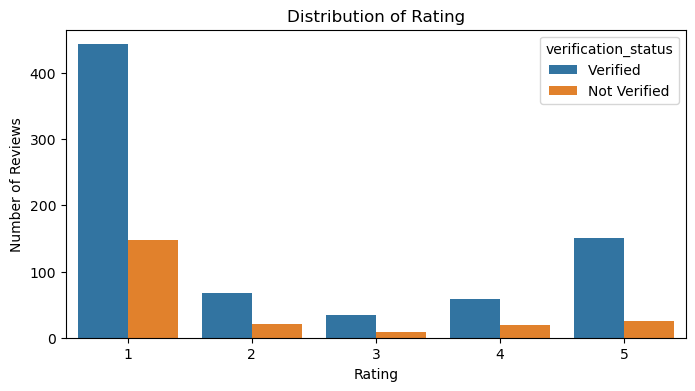

In [57]:
# Distribution of Ratings Visualization
plt.figure(figsize=(8, 4))
sns.countplot(x='rating', data=df, hue='verification_status')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

The bar chart depicts the distribution of customer ratings, where we observe a substantial inclination towards lower ratings. This suggests prevalent customer dissatisfaction, warranting further investigation and action from British Airways.

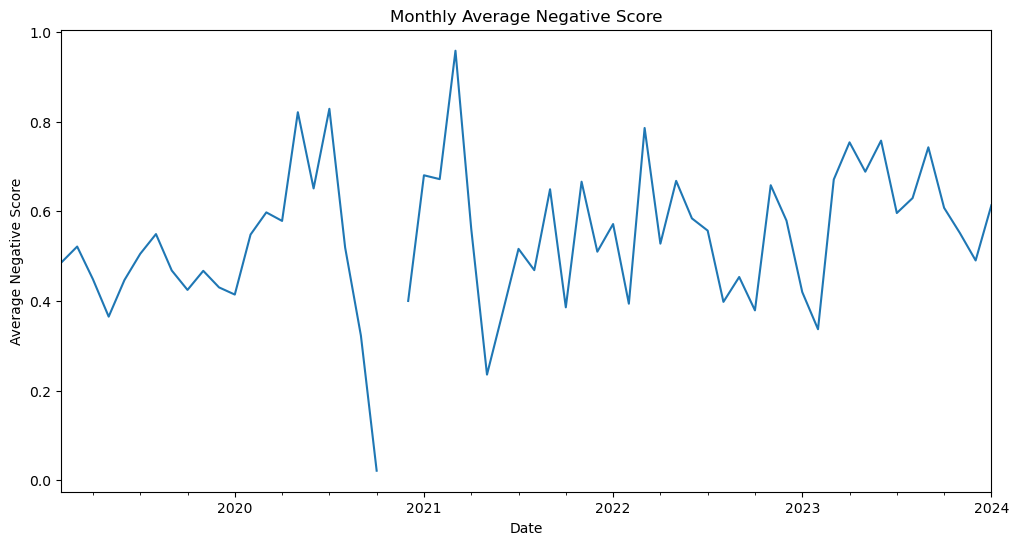

In [59]:
# Monthly Average Negative Score Visualization
plt.figure(figsize=(12, 6))
df.set_index('date').resample('M')['neg_score'].mean().plot()
plt.title('Monthly Average Negative Score')
plt.xlabel('Date')
plt.ylabel('Average Negative Score')
plt.show()

The line graph indicates the trend in the average negative sentiment score over time. A notable peak in March 2021 suggests a period of increased customer grievances, potentially linked to service disruptions or policy changes during that time.

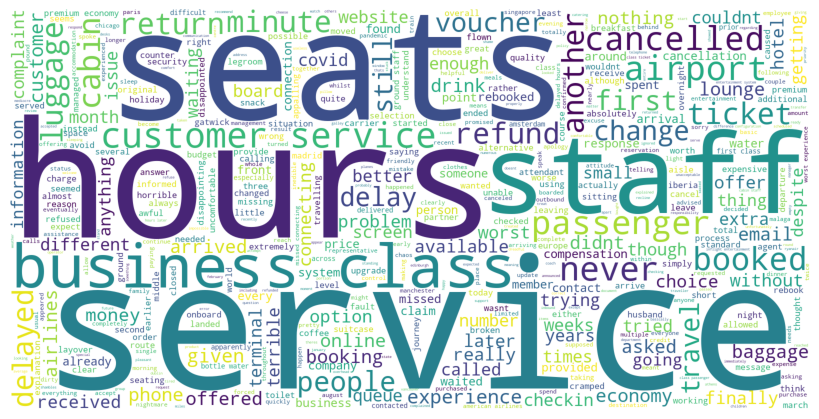

In [30]:
# Generate a word cloud for low rating reviews
wordcloud = WordCloud(
    max_words=500,
    width=1600,
    height=800,
    min_word_length=5,
    background_color='white',
    colormap='viridis',  # Use a different color map
    contour_width=1,
    contour_color='steelblue'  # Add contour to the words
).generate(" ".join(df[df.rating == 1].cleaned_review))

# Plot the word cloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

The word cloud concentrates on the most frequent terms used in the lowest-rated reviews. Prominent words such as "customer service," "cancelled," "delay," and "refund" are indicative of the primary concerns expressed by passengers.

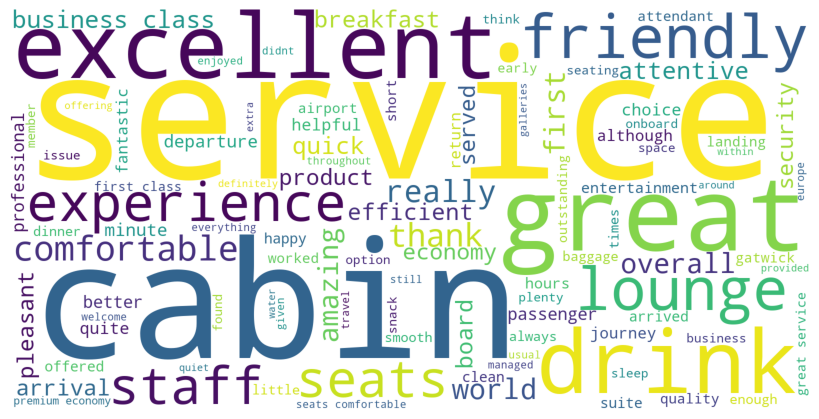

In [31]:
# Generate a word cloud for high rating reviews
wordcloud = WordCloud(
    max_words=100,
    width=1600,
    height=800,
    min_word_length=5,
    background_color='white',
    colormap='viridis',  # Use a different color map
    contour_width=1,
    contour_color='steelblue'  # Add contour to the words
).generate(" ".join(df[df.rating == 5].cleaned_review))

# Plot the word cloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


The analysis reveals a trend of negative sentiment in customer reviews, particularly centered around the customer service experience. British Airways could benefit from a targeted approach to address these service issues, potentially improving their overall customer satisfaction. The temporal fluctuations in sentiment scores also highlight the need for ongoing monitoring to swiftly identify and rectify service-related issues as they arise.

